# TODO get all the steps running without emitting any warnings

# Change in exposure to heatwaves

Heat waves are defined here using the index proposed in Jacob et al. [2013] (but using daily minimum temperature data instead of maximum), as any period of more than 3 consecutive days (i.e 4 or more days) exceeding the 99th percentile of the daily minimum temperature of all DJF/JJA seasons for the recent past (1986-2005). The change in heatwave frequency ∆H is the difference between the projected number of heat waves and the number of heat waves in the recent historic period (1986-2005).
  
The heatwave risk Hˆ is then measured as the change in heatwave frequency
∆H multiplied by the population;

$$
H = ∆H(x,t)P(x,t)
$$

where P(x,t) is the population of people aged over 65 at location x at time t.


## Alternative approach: number of days of heatwave

Instead of simply counting the number of periods over the threshold longer than 3 days, why not simply sum the total number of days of 'heatwave condition'. I beleive this to be a much better indicator since it should capture both the number of heatwaves and the change in length of heatwaves. With the previous method, a 3-week heatwave counts the same as a 4 days one.


The heatwave indicator is therefor in units of 'Days of heatwave conditions'.

The heatwave exposure indicator is in days-person exposed - which can be thought of as the total number of days of heatwave experienced (e.g. 2 people experiencing the same day of heatwave, a total of 2 days of heatwaves have been experienced)

In [1]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


from scipy import stats
from numba import jit
from tqdm import tnrange, tqdm_notebook

import population_tools
from config import DATA_SRC, POP_DATA_SRC

import matplotlib as mpl
# mpl.rc('figure', titlesize=12)

## Adjust by population over 65

- Use the proportion in 2005 and assume that this does not change significantly in the period of interest from 2000-2015

In [4]:
UN_DEMOGRAPHICS_TABLE = pd.read_csv(POP_DATA_SRC / 'UN' / 'WPP2015_INT_F2B_Annual_Population_Indicators_Percentage.csv')

country_shapefile = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

# COUNTRY_POLY_SHP
COUNTRIES = gpd.read_file(str(country_shapefile))
# Translate to match raster coordinates
COUNTRIES.geometry = COUNTRIES.translate(xoff=180)

# Remove missing UN A3 code fields, convert to int and set as index
COUNTRIES.loc[COUNTRIES.un_a3 == '-099', 'un_a3'] = np.nan
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(float)
COUNTRIES = COUNTRIES[np.isfinite(COUNTRIES.un_a3)]
COUNTRIES.un_a3 = COUNTRIES.un_a3.astype(int)
COUNTRIES = COUNTRIES.set_index('un_a3')


In [5]:
def get_country_demographics_for_year(year):
    un_demographics = UN_DEMOGRAPHICS_TABLE.set_index('LocID')
    un_demographics = un_demographics[un_demographics.Variant == 'Medium']
    un_demographics = un_demographics[un_demographics.Time == year]
    return COUNTRIES.join(un_demographics['pPopTot_65_100'])

## Rasterize the population over 65 by country onto the population grid

In [6]:
pct_age_rasters = []
with population_tools.PopulationProjector('population_count_2000-2020.nc', 
                                          'water_mask_sixteenres.tif') as pop:
    for year in tnrange(2000, 2017):
        countries = get_country_demographics_for_year(year)
        raster = pop.rasterize_data(countries, 'pPopTot_65_100')
        raster *= pop.water_mask.squeeze()
        raster /= 100
        raster.shape = (*raster.shape, 1)
        pct_age_rasters.append(xr.DataArray(raster, 
                                        coords=[pop.data.latitude, pop.data.longitude, [year]], 
                                        dims=['latitude', 'longitude', 'year'], name='pop_over_65'))
        
pct_age_rasters = xr.concat(pct_age_rasters, dim='year')

In [12]:
# pct_age_rasters.to_netcdf(str(DATA_SRC / 'lancet' / 'population_over_65_b.nc'))

In [3]:
pct_age_rasters = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'population_over_65.nc'))

# TODO convert this to use and generate multi-file dataset (one per year)

# TODO save a folder full of minimas instead of one giant file

## Load weather data and save minimas
# TODO automatically check it the file exists, create if not
NOTE: only need to do this once

In [2]:
t_min_file = DATA_SRC / 'weather' / 'ecmwf' / 'era_interim_temperature_day_min.nc'
high_t_reference_file = DATA_SRC / 'lancet' / 'heatwave_high_t_reference.nc'

In [ ]:
SUBDAILY_TEMPERATURES_FOLDER = DATA_SRC / 'weather' / 'ecmwf' / 'summer_temperature'

era_alltemps = weather_ecmwf.weather_mfdataset(SUBDAILY_TEMPERATURES_FILE)
era_allmin = era_alltemps.resample('1D', dim='time').min()


# era_allmin.to_netcdf(str(t_min_file))

### Open the saved minimas file

In [7]:
era_allmin = xr.open_dataset(t_min_file, chunks={'time': 365})
# temperatures = era_allmin.t2m
# era_allmin = xr.open_dataset(str(t_min_file))

## Calculate the 99th percentile 1986-2005

Only need to do this once, afterwards load the saved file

In [7]:
# recent_past = era_allmin.sel(time=slice('1986-01-01', '2005-12-31'))
# high_t_reference = recent_past.quantile(0.99, dim='time')
# high_t_reference.to_netcdf(str(high_t_reference_file))

### Load the high-t reference file

In [8]:
high_t_reference = xr.open_dataset(str(high_t_reference_file))
high_t_reference = high_t_reference.t2m.load()

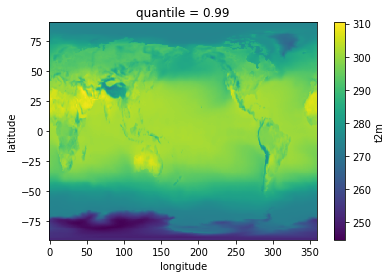

In [11]:
(high_t_reference -273).plot()

## For period of interest, select where t > tref

In [5]:
@jit("int64[:,:](b1[:,:,:])")
def fast_heatwaves_lengths(dataset_year_asbool):
    
    last_slice = None
    accumulator = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    lengther = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    
    for i in range(1, dataset_year_asbool.shape[0]):
        last_slice = dataset_year_asbool[i-1, :, :]
        data_slice = dataset_year_asbool[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add the length of the accumulator where the sequences are ending and are > 3
        # TODO should the length include the first 3 days?
        lengther[mask & (accumulator > 3)] += accumulator[mask & (accumulator > 3)]
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return lengther

@jit("int64[:,:](b1[:,:,:])")
def fast_heatwaves_counts(dataset_year_asbool):
    
    last_slice = None
    accumulator = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    counter = np.zeros(dataset_year_asbool.shape[1:], dtype=np.int64)
    
    for i in range(1, dataset_year_asbool.shape[0]):
        last_slice = dataset_year_asbool[i-1, :, :]
        data_slice = dataset_year_asbool[i, :, :]

        # Add to the sequence length counter at all positions
        # above threshold at prev time step
        accumulator[last_slice] += 1
        
        # End of sequence is where prev is true and current is false
        # True where prev and not current
        mask = last_slice & np.logical_not(data_slice)
        
        # Add one the the counter where the sequences are ending AND > 3
        counter[mask & (accumulator > 3)] += 1
        # Reset the accumulator where current slice is empty
        accumulator[np.logical_not(data_slice)] = 0
            
    return counter


def get_summer_temperatures(year, temperatures):
    t_yr = temperatures.sel(time=f'{year}')
    lat_north = temperatures.latitude[temperatures.latitude >= 0]
    lat_south = temperatures.latitude[temperatures.latitude < 0]
    
    tnh = t_yr.sel(latitude=lat_north)
    tnh = tnh.where(t_yr['time.season'] == 'JJA')

    tsh = t_yr.sel(latitude=lat_south)
    tsh = tsh.where(t_yr['time.season'] == 'DJF')

    
    t_yr = xr.concat([tnh, tsh], 
                     dim='latitude')
    t_yr = t_yr.fillna(-9999)
    return t_yr


def heatwave_length_for_year(year, temperatures, reference):
    dataset_year = get_summer_temperatures(year, temperatures)
    
    dataset_year_asbool = xr.ufuncs.isfinite(dataset_year.where(dataset_year > reference)).values
    
    counter = fast_heatwaves_lengths(dataset_year_asbool)

    counter.shape = (*counter.shape, 1)
    counter = xr.DataArray(counter, 
                            coords=[dataset_year.latitude.values,
                                    dataset_year.longitude.values,
                                    [year]
                                   ], 
                           dims=['latitude', 'longitude', 'year'],
                           name='heatwave_count'
                          )
    
    return counter


def heatwave_count_for_year(year, temperatures, reference):
    dataset_year = get_summer_temperatures(year, temperatures)
    
    dataset_year_asbool = xr.ufuncs.isfinite(dataset_year.where(dataset_year > reference)).values
    
    counter = fast_heatwaves_counts(dataset_year_asbool)

    counter.shape = (*counter.shape, 1)
    counter = xr.DataArray(counter, 
                            coords=[dataset_year.latitude.values,
                                    dataset_year.longitude.values,
                                    [year]
                                   ], 
                           dims=['latitude', 'longitude', 'year'],
                           name='heatwave_count'
                          )
    
    return counter    

In [7]:

heatwaves_counts = xr.concat((heatwave_count_for_year(year, temperatures, high_t_reference) 
                                  for year in tnrange(1986, 2017)), 
                             dim='year').astype(float)


In [8]:
heatwaves_lengths = xr.concat((heatwave_length_for_year(year, temperatures, high_t_reference)
                                   for year in tnrange(1986, 2017)),
                              dim='year').astype(float)

In [9]:
heatwaves_counts.to_netcdf(str(DATA_SRC / 'lancet'/'heatwaves_counts_all_years.nc'))
heatwaves_lengths.to_netcdf(str(DATA_SRC / 'lancet'/'heatwaves_lengths_all_years.nc'))

### Open saved results

In [4]:
heatwaves_counts = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_counts_all_years.nc'))
heatwaves_lengths = xr.open_dataarray(str(DATA_SRC / 'lancet'/'heatwaves_lengths_all_years.nc'))

### Calculate historical and delta
### Get the area-weighted time series for counts and lengths

In [7]:
# Take average period to match Temperature Change calculations
heatwaves_counts_historical = heatwaves_counts.sel(year=slice(1986,2008)).mean(dim='year')
heatwaves_counts_delta = heatwaves_counts.sel(year=slice(2000,2017)) - heatwaves_counts_historical

In [8]:
heatwaves_lengths_historical = heatwaves_lengths.sel(year=slice(1986,2008)).mean(dim='year')
heatwaves_lengths_delta = heatwaves_lengths.sel(year=slice(2000,2017)) - heatwaves_lengths_historical

In [9]:
cos_lat = xr.ufuncs.cos(xr.ufuncs.radians(heatwaves_lengths.latitude))
heatwaves_counts_ts = (heatwaves_counts_delta * cos_lat).mean(dim=['latitude', 'longitude'])
heatwaves_lengths_ts = (heatwaves_lengths_delta * cos_lat).mean(dim=['latitude', 'longitude'])


In [10]:
heatwaves_counts_delta = heatwaves_counts_delta.compute()

## Heatwave count plots

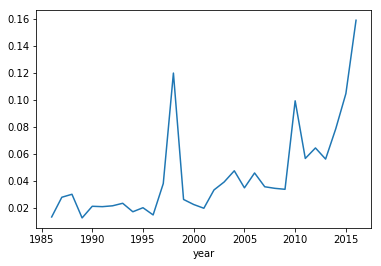

In [14]:
(heatwaves_counts * cos_lat).mean(dim=['latitude', 'longitude']).plot()
plt.ylabel('Mean heatwaves count')

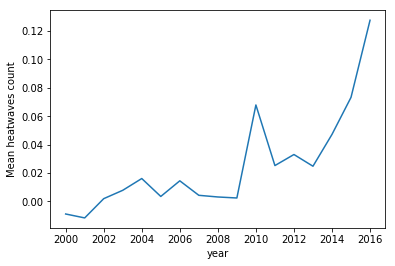

In [16]:
heatwaves_counts_ts.plot()
plt.ylabel('Mean heatwaves count change')
# plt.savefig('change_mean_heatwaves_count.png')

# Project the heatwave changes onto the population

In [ ]:
# TODO use this function everywhere
def project_to_population(anom_data, demographics=None, norm=False, start_year=2000, end_year=2017):
    
    with population_tools.PopulationProjector('population_count_2000-2020_highres.nc',
                                              'water_mask_eightres.tif') as pop:
        if demographics:
            pop_sel = (pop.data * demographics).compute()
        else:
            pop_sel = pop.data
        pop_sum = pop_sel.sum(dim=['latitude', 'longitude'], skipna=True)

        def do(year):
            proj = pop.project_param(anom_data.sel(year=year))
            proj = proj * pop_sel.sel(year=year)
            if norm:
                proj = proj / pop_sum.sel(year=year)
            return proj.compute()
        
        exposures = xr.concat((do(year) for year in range(start_year, end_year+1)), dim='year')   
        exposures_ts = exposures.sum(dim=['latitude', 'longitude'],
                                     skipna=True).compute()
        return exposures_ts

# TODO clean up. I think we can ditch the counts and keep only lengths and N exposures
## Plot the heatwave counts mean against the population weighted mean

In [2]:
heatwaves_c_pop_ts = project_to_population(heatwaves_counts_delta, pct_age_rasters, norm=True)


In [12]:
# Save results
heatwaves_c_pop_ts.to_netcdf(str(DATA_SRC / 'lancet' / 'heatwave_c_change_pop.nc'))

In [11]:
# Retrieve saved results
heatwaves_c_pop_ts = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'heatwave_c_change_pop.nc'))

Plot the change in mean number of heatwaves over time, comparing the global average with the population weighted average

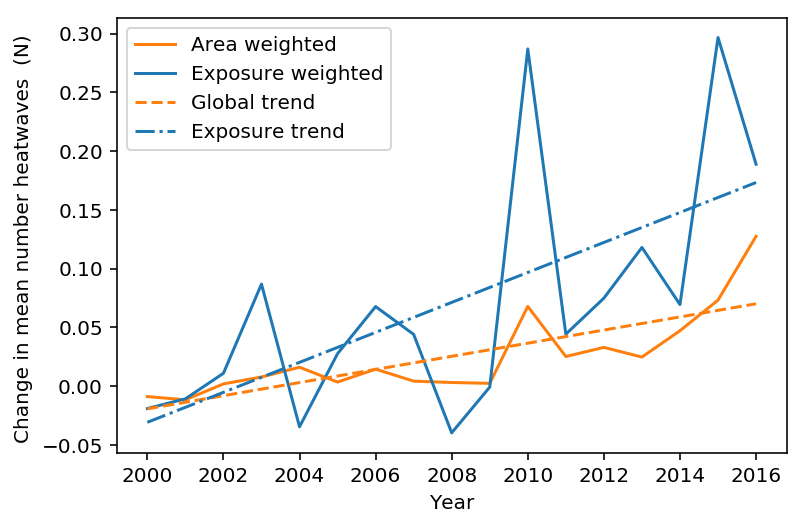

In [69]:
heatwaves_counts_ts.plot(color='C1',label='Area weighted')
heatwaves_c_pop_ts.plot(color='C0',label='Exposure weighted')


anom_reg = stats.linregress(heatwaves_counts_ts.year.values, heatwaves_counts_ts.values)
anom_reg = (anom_reg.slope * heatwaves_counts_ts.year) + anom_reg.intercept

exposures_reg = stats.linregress(heatwaves_c_pop_ts.year.values, heatwaves_c_pop_ts.values)
exposures_reg = (exposures_reg.slope * heatwaves_c_pop_ts.year) + exposures_reg.intercept

anom_reg.plot.line('--', color='C1', label='Global trend')
exposures_reg.plot.line('-.', color='C0', label='Exposure trend')


plt.xlabel('Year')
plt.ylabel('Change in mean number heatwaves  (N) ')
plt.legend()
plt.savefig('heatwaves_count_comp_2000-2016.png', dpi=300, bbox_inches='tight')
plt.savefig('heatwaves_count_comp_2000-2016.pdf', bbox_inches='tight')



#### Show the historical mean

In [30]:
with population_tools.PopulationProjector('population_count_2000-2020_highres.nc',
                                     'water_mask_eightres.tif') as pop:
    
    # For the historical part just take the population in 2000 as a rough mid point
    year = 2000
    
    heatwave_c_pop_historical = (pop.project(year, heatwaves_counts_historical) * pct_age_rasters.sel(year=year))
    heatwave_c_pop_historical = (heatwave_c_pop_historical / pop_sum.sel(year=year)).sum(dim=['latitude', 'longitude']).compute()



/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2403: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


In [38]:
print('Global mean number of heatwaves', 
      np.asscalar((heatwaves_counts_historical * cos_lat).mean(dim=['latitude', 'longitude'])))

Global mean number of heatwaves 0.03131808599617787


In [39]:
print('Pop over 65 weighted mean number of heatwaves', 
np.asscalar(heatwave_c_pop_historical) )

Pop over 65 weighted mean number of heatwaves 0.050050407392664496


## Plot the heatwaves lengths area mean against population weighted mean

In [13]:
heatwaves_l_pop_ts = project_to_population(heatwaves_lengths_delta, pct_age_rasters, norm=True)

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:476: RuntimeWarning: overflow encountered in true_divide
  o = func(*args, **kwargs)
/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2544: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


In [14]:
# Save results
heatwaves_l_pop_ts.to_netcdf(str(DATA_SRC / 'lancet' / 'heatwave_l_change_pop.nc'))

In [12]:
# Retrieve saved results
heatwaves_l_pop_ts = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'heatwave_l_change_pop.nc'))

In [20]:
heatwaves_counts_ts.name = 'heatwave_counts'
heatwaves_c_pop_ts.name = 'heatwave_counts_pop'

heatwaves_lengths_ts.name = 'heatwave_lengths'
heatwaves_l_pop_ts.name = 'heatwave_lengths_pop'

writer = pd.ExcelWriter(str(DATA_SRC / 'lancet' / 'heatwave_exposure.xlsx'))


output = heatwaves_counts_ts.to_dataframe().join(heatwaves_c_pop_ts.to_dataframe())
output.columns = ['Area weighted change N count', 'Exposure weighted change mean N count']

output.to_excel(writer, sheet_name='heatwaves_counts')

output = heatwaves_lengths_ts.to_dataframe().join(heatwaves_l_pop_ts.to_dataframe())
output.columns = ['Area weighted change (days)', 'Exposure weighted change (days)']

output.to_excel(writer, sheet_name='heatwaves_lengths')

writer.save()


Plot the change in mean length of heatwaves over time, comparing the global average with the population weighted average

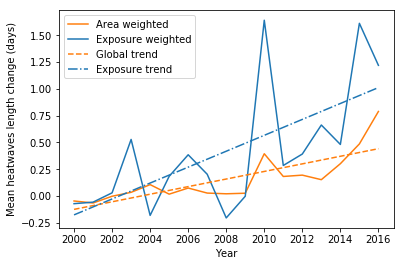

In [18]:
heatwaves_lengths_ts.plot(color='C1',label='Area weighted')
heatwaves_l_pop_ts.plot(color='C0',label='Exposure weighted')


anom_reg = stats.linregress(heatwaves_lengths_ts.year.values, heatwaves_lengths_ts.values)
anom_reg = (anom_reg.slope * heatwaves_lengths_ts.year) + anom_reg.intercept

exposures_reg = stats.linregress(heatwaves_l_pop_ts.year.values, heatwaves_l_pop_ts.values)
exposures_reg = (exposures_reg.slope * heatwaves_l_pop_ts.year) + exposures_reg.intercept

anom_reg.plot.line('--', color='C1', label='Global trend')
exposures_reg.plot.line('-.', color='C0', label='Exposure trend')


plt.xlabel('Year')
plt.ylabel('Mean heatwaves length change (days)')
plt.legend()
plt.savefig('heatwaves_length_comp_2000-2016.png', dpi=300, bbox_inches='tight')
plt.savefig('heatwaves_length_comp_2000-2016.pdf', bbox_inches='tight')

## Plot the total number of exposure events (where one exposure event = 1 person * 1 heatwave)

In [12]:
pct_age_rasters = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'population_over_65.nc'))

In [29]:
heatwaves_pop_events_ts = project_to_population(heatwaves_counts_delta, pct_age_rasters, norm=True)

In [17]:
# Save results
heatwaves_pop_events_ts.to_netcdf('heatwave_exposure_events.nc')

In [22]:
# open saved results
heatwaves_pop_events_ts = xr.open_dataarray('heatwave_exposure_events.nc')

In [21]:
heatwaves_pop_events_ts.to_dataframe('heatwave_exposure_events').to_csv('global_results/heatwaves_n_exposure_change_2000-2016.csv')

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


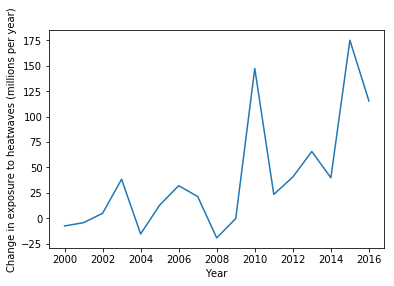

In [16]:
(heatwaves_pop_events_ts / 1e6).plot()

plt.xlabel('Year')
plt.ylabel('Change in exposure to heatwaves (millions per year)')
plt.savefig('global_results/heatwaves_n_exposure_2000-2016.png', dpi=300, bbox_inches='tight')
plt.savefig('global_results/heatwaves_n_exposure_2000-2016.pdf', bbox_inches='tight')


### Show the historical average (the baseline against which these are calculated)

In [19]:
with population_tools.PopulationProjector('population_count_2000-2020_highres.nc',
                                     'water_mask_eightres.tif') as pop:
    
    # For the historical part just take the population in 2000 as a rough mid point
    year = 2000
    
    heatwave_events_historical = (pop.project(year, heatwaves_counts_historical) * pct_age_rasters.sel(year=year))
    heatwave_events_historical = (heatwave_events_historical).sum(dim=['latitude', 'longitude']).compute()

/Users/jonathanchambers/miniconda3/envs/lancet/lib/python3.6/site-packages/dask/array/core.py:2403: RuntimeWarning: invalid value encountered in greater
  return function(*args2, **kwargs)


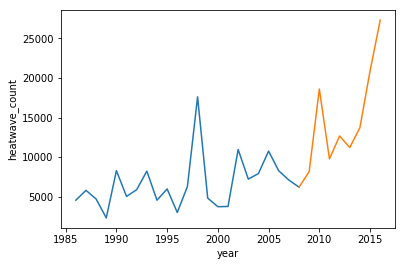

In [18]:
heatwaves_counts.sel(year=slice(1986,2008)).sum(dim=['latitude', 'longitude']).plot()
heatwaves_counts.sel(year=slice(2008, None)).sum(dim=['latitude', 'longitude']).plot()

In [27]:
np.asscalar(heatwave_events_historical)

19296532.715252105

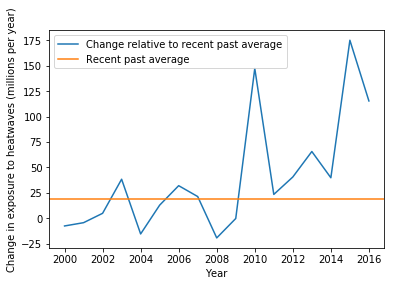

In [29]:
(heatwaves_pop_events_ts / 1e6).plot(label='Change relative to recent past average')
plt.axhline(np.asscalar(heatwave_events_historical) / 1e6, color='C1', label='Recent past average')
plt.xlabel('Year')
plt.ylabel('Change in exposure to heatwaves (millions per year)')
plt.legend()
plt.savefig('global_results/heatwave_exposures_with_baseline.png')